# Tutorial on how to create a new PRF model from FFI

In [1]:
import numpy as np
from scipy import sparse
import lightkurve as lk

path = os.path.dirname(os.getcwd())

sys.path.append(path)
from kepler_apertures import KeplerFFI

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# Load a KeplerFFI object

First we define the quarter and channel we want to use to create the PRF models.
Then we initialize an object of the `KeplerFFI` class that will load the corresponding FFI (it will download it if the file is not local) and establish the necessary attributes.
During initialization, `KeplerFFI` will query the Gaia EDR3 (by default) to obtain all sources observed in the field, the query results are cached.
It will clean contaminated sources within 2'', it will remove all sources fainter than G = 20 mag and all saturated pixels, including creating mask around them to remove flares.

In [36]:
ch = 82
qu = 15

psf = KeplerFFI(quarter=qu, channel=ch, plot=True, save=False)

Will query with this (ra, dec, radius, epoch):  [283.07228568] [43.29674079] [1.1781465361581342] 2012.8468588835049
Loading query from file...
../data/catalogs/ffi/15/channel_82_gaia_xmatch.csv
Cleaning sources table...
Saturated pixels 4471: 
Bright pixels 87692: 
Total Gaia sources 8046: 


One can plot the saturated and bright/halo/flares pixel masks

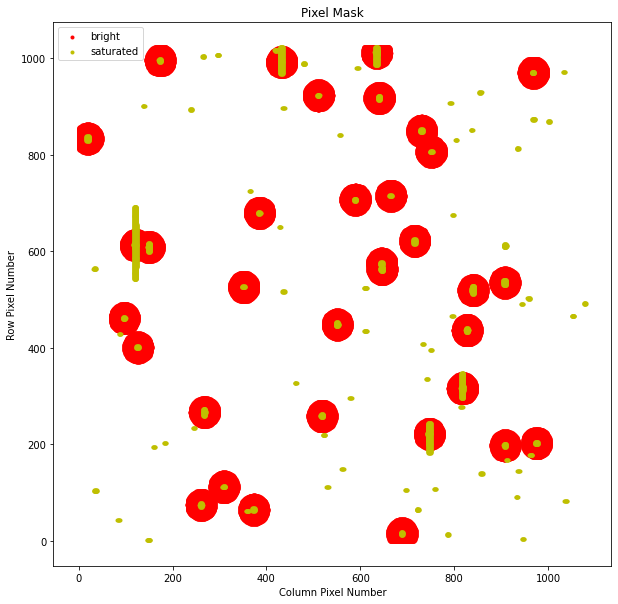

In [37]:
# plot rejected pixels due to saturation or bright-star halos
_ = psf.plot_pixel_masks()

And plot a nice figure of the image in the pixel space with the WCS projection. The source catalog can be overplot, but this will yield a very crowded figure.

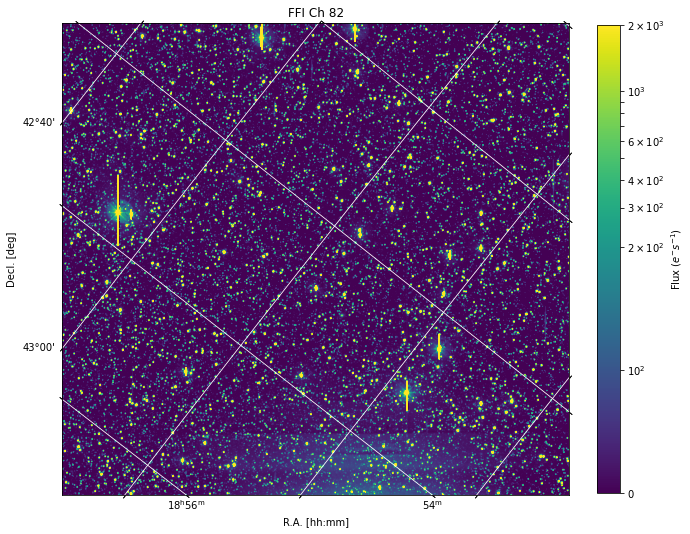

In [38]:
# plot FFI ch image
_ = psf.plot_image(sources=False)

We can access the catalog of observed sources as

In [39]:
psf.sources.head()

,designation,ra,ra_error,dec,dec_error,pmra,pmdec,parallax,parallax_error,phot_g_n_obs,...,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,col,row
0,Gaia DR2 2105295494220508288,282.988627,0.048761,43.594856,0.056369,-2.221538,5.958805,1.187718,0.056633,239,...,21,1805.588246,8.333771,17.209840,22,4054.548649,15.974176,15.742064,768.762568,421.837140
1,Gaia DR2 2105327444478261888,283.180525,0.088868,43.853855,0.089823,-1.970348,-1.567725,0.432003,0.092912,182,...,19,836.248347,13.233092,18.045550,18,1440.532122,11.944718,16.865612,874.968540,178.039008
2,Gaia DR2 2105295872177630208,282.949089,0.032836,43.627377,0.036023,-1.491618,-6.792102,0.230553,0.037856,256,...,27,3314.319377,19.768492,16.550402,27,5162.682338,9.021092,15.479732,807.920611,423.888737
3,Gaia DR2 2105337305723270656,283.136520,0.064453,44.092324,0.094110,-2.274940,-7.512252,0.180446,0.088216,241,...,22,989.290675,9.571332,17.863080,26,1351.694496,7.755731,16.934723,1062.230176,66.972053
4,Gaia DR2 2105332121701651072,282.974417,0.039498,43.981317,0.048751,0.147253,1.292725,0.703517,0.048642,251,...,26,1950.632560,10.343398,17.125950,24,3538.640861,13.310956,15.889829,1048.767923,212.064418


Before fitting the spline model to the PRF, first we need to create a couple of `scipy` sparse matrices and transform the data into polar coordinates.
These two steps are condensed in one call `._create_sparse()`.

This step usually takes some time. We are creating sparse matrices with shape [N_sources x N_pix], tipically in the order of [10k x 1M], with ~100k non-zero values.

In [40]:
# create sparse arrays for later use
psf._create_sparse()

Gaia sources:   0%|          | 0/8046 [00:00<?, ?it/s]

to polar coordinates...


Now we compute first estimate of the PSF edges for every source in the catalog, this helps on removing background pixels that do not contain information of the PRF shape.
This is done by fitting a quadratic polynomial to the Flux as a function of the radius (from the center of the source), and defining a cut where the flux reaches the level of the background.
The function `._get_source_mask()` do this and and include parameters that can be user defined, such as the maximum and minimum radius limit allowed to cap the model fitting, the flux cut off (flux level of the background), and the type of design matrix used for the model fitting.

In [41]:
# the psf.plot and psf.save control the global plotting and saving preferences
psf.plot = True
psf.save = True
# find PSF edges as fn of flux to then limit the radius of the PSF fitting
psf._get_source_mask(upper_radius_limit=5, lower_radius_limit=1.1, flux_cut_off=50, dm_type="rf-quadratic")

# we clean the source mas removing contaminated pixels
psf._get_uncontaminated_source_mask()

Finally we can fit our spline model to the data in polar coordinates to obtain a very nice PRF model.
User parameters are the number of knots for both, radial and angle, coordinates, and for the cut off where background pixels are rejected.

The method `_build_psf_model()` will save or not the model depending on the value of `psf.save`

The method also includes nice plots of the data and model in polar and Cartesian coordinates for inspection.

Total number of pixels data used for model fitting:  (53181,)


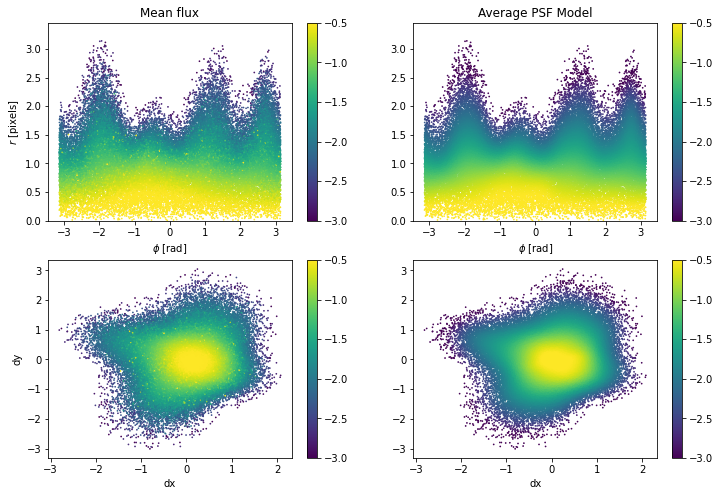

In [42]:
# fit PSF model in polar coordinates to the filtered/clean data
psf.save = False
psf._build_psf_model(n_r_knots=5, n_phi_knots=15, flux_cut_off=1)

One can access the PRF model via the attribute `psf_w`, the design matrix in `design_matrix` and the evaluation of the model in the FFI pixel data at `mean_model`.

The model weights and hyperparameters for the design matrix can be stored in a CSV file that has index row the channel number and multileve-columns as (quarter, parameter).
The function `psf.save_model` saves the values in file `../res/ffi_prf_models_v0.1.1.csv`.
The original PRF models calculated for the paper are located in "../res/ffi_prf_models_v0.1.0.csv".

In [116]:
psf.save_model(path=None)